# Multilayer perceptron on CIFAR-10

## Imports

In [71]:
import keras
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint   
from sklearn.preprocessing import  MinMaxScaler
from sklearn.decomposition import PCA
from time import time as runtime
import sys
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

stdout = sys.stdout
sys.stdout = open('/dev/null', 'w')
sys.stdout = stdout

## Loading Data & printing shapes

In [72]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("trainig data shape  : ",x_train.shape)
print("trainig labels shape: ",y_train.shape)

print("testing data shape  : ",x_test.shape)
print("testing labels shape: ",y_test.shape)


# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
ten = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

trainig data shape  :  (50000, 32, 32, 3)
trainig labels shape:  (50000, 1)
testing data shape  :  (10000, 32, 32, 3)
testing labels shape:  (10000, 1)


## Data exploration
First data visualisation without any pre-processing on it.
Printing 10 first images from the training set. 

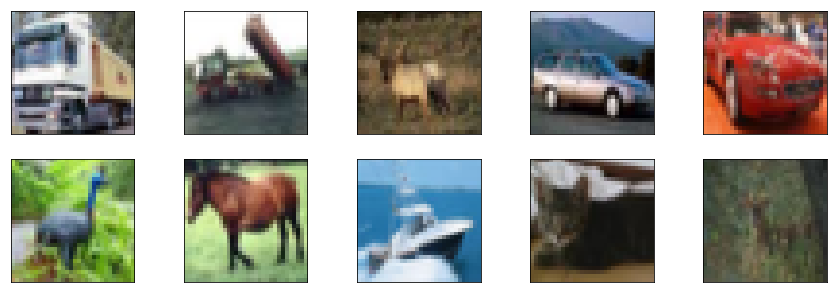

In [73]:
figure1 = plt.figure(figsize=(15,5))
aaa=x_test
for i in range(1,11):
    images = figure1.add_subplot(2, 5, i , xticks=[], yticks=[])
    images.imshow(np.squeeze(x_train[i]))

## Data normalization

In [74]:
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

# PCA

In [75]:
x_train = x_train.reshape((50000, 3072))
x_test = x_test.reshape((10000, 3072))

t = runtime()
pca = PCA(n_components=100)
pca.fit(x_train)


print("training PCA on training set takes: %.1f" % (runtime()-t))
t = runtime()
x_train = pca.transform(x_train)
x_test  = pca.transform(x_test)
print("Transforming training & testing set takes: %.1f" % (runtime()-t))


x_train = x_train.reshape((50000,10,10))
x_test = x_test.reshape((10000,10,10))


training PCA on training set takes: 12.6
Transforming training & testing set takes: 1.2


## Labels onehote Encoding & Spliting Testing data into training (90%) /Validation (10%) 

In [76]:
len(ten)
# encoding labels to onehot

y_train = keras.utils.to_categorical(y_train, len(ten))
y_test  = keras.utils.to_categorical(y_test, len(ten))
print("[after onehote encoding]")
print("trainig labels shape: ",y_train.shape)
print("testing labels shape: ",y_test.shape,"\n")

# training set spliting into training (45000) and validation (5000) sets
(x_train, x_validation) = x_train[5000:], x_train[:5000]
(y_train, y_validation) = y_train[5000:], y_train[:5000]

print("[after spliting]")
print("trainig   data shape  : ",x_train.shape ,x_train.shape[0], 'examples')
print("validation data shape : ",x_validation.shape," ",x_validation.shape[0],  'examples')
print("testing   data shape  : ",x_test.shape,x_test.shape[0], 'examples')


[after onehote encoding]
trainig labels shape:  (50000, 10)
testing labels shape:  (10000, 10) 

[after spliting]
trainig   data shape  :  (45000, 10, 10) 45000 examples
validation data shape :  (5000, 10, 10)   5000 examples
testing   data shape  :  (10000, 10, 10) 10000 examples


# MLP: Multilayer Perceptron Definition
https://keras.io/getting-started/sequential-model-guide/

In [77]:
#creating a sequential model &passing a list of layers instances to it
from keras.utils.vis_utils import plot_model
MLP = Sequential([ Flatten(input_shape = x_train.shape[1:]),
                   Dense(1000, activation='relu'),#a fully-connected layer with 1000 hidden units
                   Dropout(0.6),                  #helps prevent overfitting.
                   Dense(512, activation='relu'), #a fully-connected layer with 512 hidden units
                   Dropout(0.6),                  #helps prevent overfitting
                   Dense(len(ten), activation='softmax')])#a fully-connected layer with 10 hidden units
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1000)              101000    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                5130      
Total params: 618,642
Trainable params: 618,642
Non-trainable params: 0
_________________________________________________________________


# MLP: Compiling the model

In [78]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
MLP.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Training our MLP

In [79]:
#t=runtime()
checkpointer = ModelCheckpoint(filepath='MLP.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
History = MLP.fit(x_train, y_train, batch_size=200, epochs=300,
          validation_data=(x_validation, y_validation), callbacks=[checkpointer],verbose=2, shuffle=True)
#print("fitting the model took: %.1fs" % (runtime()-t))


Train on 45000 samples, validate on 5000 samples
Epoch 1/300
 - 7s - loss: 2.3922 - acc: 0.1690 - val_loss: 1.9763 - val_acc: 0.3142

Epoch 00001: val_loss improved from inf to 1.97634, saving model to MLP.weights.best.hdf5
Epoch 2/300
 - 6s - loss: 2.1308 - acc: 0.2393 - val_loss: 1.8987 - val_acc: 0.3484

Epoch 00002: val_loss improved from 1.97634 to 1.89865, saving model to MLP.weights.best.hdf5
Epoch 3/300
 - 6s - loss: 2.0318 - acc: 0.2712 - val_loss: 1.8531 - val_acc: 0.3704

Epoch 00003: val_loss improved from 1.89865 to 1.85312, saving model to MLP.weights.best.hdf5
Epoch 4/300
 - 5s - loss: 1.9733 - acc: 0.2918 - val_loss: 1.8194 - val_acc: 0.3860

Epoch 00004: val_loss improved from 1.85312 to 1.81938, saving model to MLP.weights.best.hdf5
Epoch 5/300
 - 6s - loss: 1.9304 - acc: 0.3081 - val_loss: 1.7922 - val_acc: 0.3938

Epoch 00005: val_loss improved from 1.81938 to 1.79222, saving model to MLP.weights.best.hdf5
Epoch 6/300
 - 5s - loss: 1.9058 - acc: 0.3172 - val_loss: 1


Epoch 00046: val_loss improved from 1.51361 to 1.51072, saving model to MLP.weights.best.hdf5
Epoch 47/300
 - 5s - loss: 1.5875 - acc: 0.4376 - val_loss: 1.5095 - val_acc: 0.4768

Epoch 00047: val_loss improved from 1.51072 to 1.50953, saving model to MLP.weights.best.hdf5
Epoch 48/300
 - 5s - loss: 1.5841 - acc: 0.4384 - val_loss: 1.5063 - val_acc: 0.4760

Epoch 00048: val_loss improved from 1.50953 to 1.50628, saving model to MLP.weights.best.hdf5
Epoch 49/300
 - 5s - loss: 1.5826 - acc: 0.4370 - val_loss: 1.5031 - val_acc: 0.4756

Epoch 00049: val_loss improved from 1.50628 to 1.50307, saving model to MLP.weights.best.hdf5
Epoch 50/300
 - 5s - loss: 1.5818 - acc: 0.4414 - val_loss: 1.5011 - val_acc: 0.4786

Epoch 00050: val_loss improved from 1.50307 to 1.50111, saving model to MLP.weights.best.hdf5
Epoch 51/300
 - 5s - loss: 1.5751 - acc: 0.4406 - val_loss: 1.4981 - val_acc: 0.4788

Epoch 00051: val_loss improved from 1.50111 to 1.49811, saving model to MLP.weights.best.hdf5
Epoch


Epoch 00092: val_loss improved from 1.41397 to 1.41254, saving model to MLP.weights.best.hdf5
Epoch 93/300
 - 5s - loss: 1.4762 - acc: 0.4756 - val_loss: 1.4094 - val_acc: 0.5072

Epoch 00093: val_loss improved from 1.41254 to 1.40936, saving model to MLP.weights.best.hdf5
Epoch 94/300
 - 5s - loss: 1.4744 - acc: 0.4773 - val_loss: 1.4087 - val_acc: 0.5036

Epoch 00094: val_loss improved from 1.40936 to 1.40873, saving model to MLP.weights.best.hdf5
Epoch 95/300
 - 5s - loss: 1.4734 - acc: 0.4777 - val_loss: 1.4074 - val_acc: 0.5058

Epoch 00095: val_loss improved from 1.40873 to 1.40739, saving model to MLP.weights.best.hdf5
Epoch 96/300
 - 5s - loss: 1.4654 - acc: 0.4783 - val_loss: 1.4069 - val_acc: 0.5044

Epoch 00096: val_loss improved from 1.40739 to 1.40692, saving model to MLP.weights.best.hdf5
Epoch 97/300
 - 5s - loss: 1.4694 - acc: 0.4787 - val_loss: 1.4045 - val_acc: 0.5068

Epoch 00097: val_loss improved from 1.40692 to 1.40455, saving model to MLP.weights.best.hdf5
Epoch


Epoch 00139: val_loss improved from 1.34756 to 1.34676, saving model to MLP.weights.best.hdf5
Epoch 140/300
 - 5s - loss: 1.4006 - acc: 0.5036 - val_loss: 1.3458 - val_acc: 0.5250

Epoch 00140: val_loss improved from 1.34676 to 1.34579, saving model to MLP.weights.best.hdf5
Epoch 141/300
 - 5s - loss: 1.3988 - acc: 0.5049 - val_loss: 1.3447 - val_acc: 0.5252

Epoch 00141: val_loss improved from 1.34579 to 1.34471, saving model to MLP.weights.best.hdf5
Epoch 142/300
 - 5s - loss: 1.3905 - acc: 0.5041 - val_loss: 1.3424 - val_acc: 0.5264

Epoch 00142: val_loss improved from 1.34471 to 1.34243, saving model to MLP.weights.best.hdf5
Epoch 143/300
 - 5s - loss: 1.3886 - acc: 0.5031 - val_loss: 1.3395 - val_acc: 0.5280

Epoch 00143: val_loss improved from 1.34243 to 1.33955, saving model to MLP.weights.best.hdf5
Epoch 144/300
 - 5s - loss: 1.3909 - acc: 0.5076 - val_loss: 1.3399 - val_acc: 0.5268

Epoch 00144: val_loss did not improve from 1.33955
Epoch 145/300
 - 5s - loss: 1.3923 - acc: 0


Epoch 00187: val_loss improved from 1.29804 to 1.29584, saving model to MLP.weights.best.hdf5
Epoch 188/300
 - 5s - loss: 1.3308 - acc: 0.5265 - val_loss: 1.2953 - val_acc: 0.5452

Epoch 00188: val_loss improved from 1.29584 to 1.29530, saving model to MLP.weights.best.hdf5
Epoch 189/300
 - 5s - loss: 1.3327 - acc: 0.5237 - val_loss: 1.2952 - val_acc: 0.5452

Epoch 00189: val_loss improved from 1.29530 to 1.29516, saving model to MLP.weights.best.hdf5
Epoch 190/300
 - 5s - loss: 1.3308 - acc: 0.5245 - val_loss: 1.2939 - val_acc: 0.5452

Epoch 00190: val_loss improved from 1.29516 to 1.29391, saving model to MLP.weights.best.hdf5
Epoch 191/300
 - 5s - loss: 1.3282 - acc: 0.5264 - val_loss: 1.2936 - val_acc: 0.5444

Epoch 00191: val_loss improved from 1.29391 to 1.29357, saving model to MLP.weights.best.hdf5
Epoch 192/300
 - 5s - loss: 1.3245 - acc: 0.5260 - val_loss: 1.2917 - val_acc: 0.5446

Epoch 00192: val_loss improved from 1.29357 to 1.29174, saving model to MLP.weights.best.hdf5



Epoch 00236: val_loss improved from 1.25883 to 1.25794, saving model to MLP.weights.best.hdf5
Epoch 237/300
 - 5s - loss: 1.2775 - acc: 0.5421 - val_loss: 1.2571 - val_acc: 0.5578

Epoch 00237: val_loss improved from 1.25794 to 1.25711, saving model to MLP.weights.best.hdf5
Epoch 238/300
 - 5s - loss: 1.2744 - acc: 0.5456 - val_loss: 1.2571 - val_acc: 0.5544

Epoch 00238: val_loss did not improve from 1.25711
Epoch 239/300
 - 5s - loss: 1.2740 - acc: 0.5442 - val_loss: 1.2560 - val_acc: 0.5586

Epoch 00239: val_loss improved from 1.25711 to 1.25604, saving model to MLP.weights.best.hdf5
Epoch 240/300
 - 5s - loss: 1.2713 - acc: 0.5446 - val_loss: 1.2564 - val_acc: 0.5544

Epoch 00240: val_loss did not improve from 1.25604
Epoch 241/300
 - 5s - loss: 1.2748 - acc: 0.5466 - val_loss: 1.2555 - val_acc: 0.5558

Epoch 00241: val_loss improved from 1.25604 to 1.25546, saving model to MLP.weights.best.hdf5
Epoch 242/300
 - 5s - loss: 1.2728 - acc: 0.5457 - val_loss: 1.2539 - val_acc: 0.5566


 - 5s - loss: 1.2320 - acc: 0.5602 - val_loss: 1.2283 - val_acc: 0.5648

Epoch 00286: val_loss did not improve from 1.22823
Epoch 287/300
 - 5s - loss: 1.2288 - acc: 0.5602 - val_loss: 1.2280 - val_acc: 0.5654

Epoch 00287: val_loss improved from 1.22823 to 1.22798, saving model to MLP.weights.best.hdf5
Epoch 288/300
 - 5s - loss: 1.2281 - acc: 0.5603 - val_loss: 1.2282 - val_acc: 0.5648

Epoch 00288: val_loss did not improve from 1.22798
Epoch 289/300
 - 5s - loss: 1.2269 - acc: 0.5628 - val_loss: 1.2262 - val_acc: 0.5678

Epoch 00289: val_loss improved from 1.22798 to 1.22619, saving model to MLP.weights.best.hdf5
Epoch 290/300
 - 5s - loss: 1.2330 - acc: 0.5584 - val_loss: 1.2271 - val_acc: 0.5670

Epoch 00290: val_loss did not improve from 1.22619
Epoch 291/300
 - 5s - loss: 1.2226 - acc: 0.5615 - val_loss: 1.2263 - val_acc: 0.5668

Epoch 00291: val_loss did not improve from 1.22619
Epoch 292/300
 - 5s - loss: 1.2211 - acc: 0.5622 - val_loss: 1.2273 - val_acc: 0.5674

Epoch 00292: 

# MLP: Model Evaluat. with the weights that gaving best validat. accuracy

In [80]:
#model saved to 'MLP.weights.best.hdf5'
MLP.load_weights('MLP.weights.best.hdf5')
loss,test_accuracy = MLP.evaluate(x_test, y_test)
print('\n', 'Loss value' ,loss)
print('\n', 'Testing Accuracy' ,test_accuracy)

10000/10000 [==============================] - 1s 76us/step

 Loss value 1.229475283050537

 Testing Accuracy 0.5596


In [81]:
# get predictions on the test set
y_pred = MLP.predict(x_test)


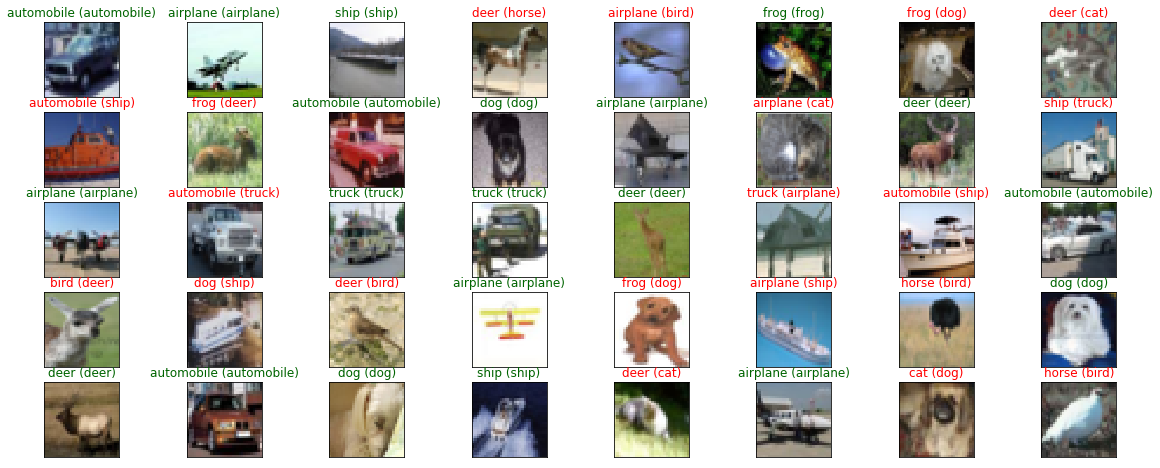

In [82]:
figure = plt.figure(figsize=(20, 8))
for i, x in enumerate(np.random.choice(10000, size=40)):
    img = figure.add_subplot(5, 8, i + 1, xticks=[], yticks=[])
    img.imshow(np.squeeze(aaa[x]))
    pred_id = np.argmax(y_pred[x])
    true_id = np.argmax(y_test[x])
    img.set_title("{} ({})".format(ten[pred_id], ten[true_id]),color=("darkgreen" if pred_id == true_id else "red"))

# MLP: Prediction Visualisation

# Visualisation

10000/10000 [==============================] - 1s 79us/step

 Loss value 1.229475283050537

 Testing Accuracy 0.5596


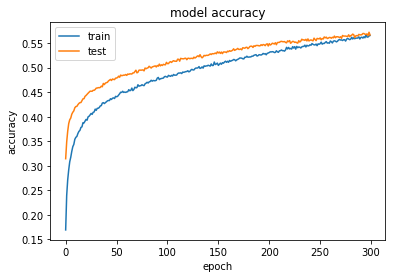

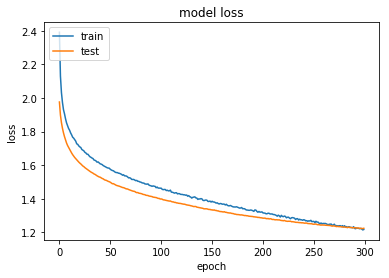

In [83]:
#model saved to 'MLP.weights.best.hdf5'
MLP.load_weights('MLP.weights.best.hdf5')
loss,test_accuracy = MLP.evaluate(x_test, y_test)
print('\n', 'Loss value' ,loss)
print('\n', 'Testing Accuracy' ,test_accuracy)

# summarize history for accuracy
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

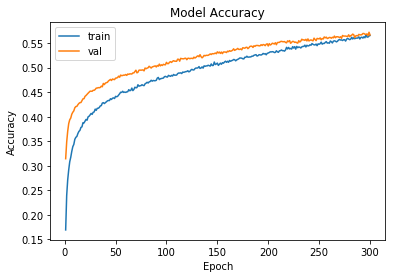

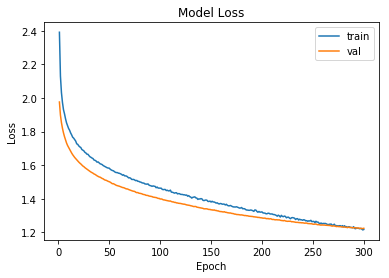

In [84]:
accuracy_length = len(History.history['acc']) 
length_val_accuracy = len(History.history['val_acc'])
loss_length = len(History.history['loss'])
length_val_accuracy = len(History.history['val_loss'])

# Visualize the reults
#fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy during training
plt.plot(range(1, accuracy_length + 1), History.history['acc'])
plt.plot(range(1, length_val_accuracy + 1), History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()
# Loss during training
plt.plot(range(1, loss_length +1), History.history['loss'])
plt.plot(range(1, length_val_accuracy +1), History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()